In [20]:
import pandas as pd
import numpy as np

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle, Circle, Ellipse, Patch
from matplotlib.lines import Line2D

from ete3 import Tree

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

Code for plotting the tree:

In [21]:
def make_comb_tree(t):
    for node in t.traverse():
        if not node.is_leaf():
            node.children = sorted(node.children, key=lambda c: len(c.get_leaves()), reverse=False)

def plot_tree(t, ax, leaf_colors=None, show_inner_nodes=False, flip=False, fontsize=10, 
              text_offset=None, axis=True, linewidth=0.8, markers=True, 
              labels=True, markersize=3, margins=(0.5, 1, 0.5, 1)): # top, right, bottom, left

    y_offset = len(t.get_leaves())
    for node in t.traverse("preorder"):
        node.x_offset = node.dist + sum(x.dist for x in node.get_ancestors())
        if node.is_leaf():
            y_offset -= 1
            node.y_offset = y_offset

    for node in t.traverse("postorder"):
        if not node.is_leaf():
            node.y_offset = sum(x.y_offset for x in node.children) / len(node.children)

    horizontal_lines = list()
    vertical_lines = list()
    node_coords = list()
    leaf_coords = list()
    max_x_offset = 0
    for node in t.traverse("postorder"):
        max_x_offset = max(max_x_offset, node.x_offset)
        node_coords.append((node.x_offset, node.y_offset))
        if node.is_leaf():
            leaf_coords.append([node.name, node.x_offset, node.y_offset])
        if not node.is_root():
            y = node.y_offset
            horizontal_lines.append(([node.up.x_offset, node.x_offset], [y, y]))
        if not node.is_leaf():
            c = sorted(node.children, key=lambda x: x.y_offset)
            bottom, top = c[0], c[-1]
            x = node.x_offset
            vertical_lines.append(([x, x],[bottom.y_offset, top.y_offset]))

    
    # shift the tree to put leaves at zero
    for i in range(len(horizontal_lines)):
        horizontal_lines[i][0][0] -= max_x_offset
        horizontal_lines[i][0][1] -= max_x_offset
    for i in range(len(vertical_lines)):
        vertical_lines[i][0][0] -= max_x_offset
        vertical_lines[i][0][1] -= max_x_offset
    for i in range(len(leaf_coords)):
        leaf_coords[i][1] -= max_x_offset

    if flip:
        l = len(leaf_coords)
        horizontal_lines = [([l-y1-1, l-y2-1], [-x1, -x2]) for ((x1, x2),(y1, y2)) in horizontal_lines]
        vertical_lines = [([l-y1-1, l-y2-1], [-x1, -x2]) for ((x1, x2),(y1, y2)) in vertical_lines]
        leaf_coords = [[n, x, y] for (n, y, x) in leaf_coords]
        
    # draw the tree:
    for x in horizontal_lines:
        ax.plot(*x, c='black', linewidth=linewidth)
    for x in vertical_lines:
        ax.plot(*x, c='black', linewidth=linewidth)

#     for tup in node_coords:
#         ax.plot(*tup, c='black', marker="o")

    if text_offset is None:
        text_offset = max_x_offset / 20

    for name, x, y in leaf_coords:
        if flip:
            verticalalignment='top'
            horizontalalignment='center'
            rotation='vertical'
        else:
            verticalalignment='center'
            horizontalalignment='left'
            rotation='horizontal'
        if labels:
            ax.text(x+text_offset, y, name, fontsize=fontsize,
                    verticalalignment=verticalalignment, 
                    horizontalalignment=horizontalalignment,
                    rotation=rotation)
        if markers:
            if leaf_colors is None:
                color = 'black'
            else:
                color = leaf_colors[name]
            ax.plot(x, y, c=color, marker="o", ms=markersize)

    if flip:
        ax.set_ylim(-margins[1], -(margins[3]-max_x_offset))
        ax.set_xlim(-margins[2], len(leaf_coords)-1+margins[0])
    else:
        ax.set_xlim(-margins[3]-max_x_offset, margins[1])
        ax.set_ylim(-margins[2], len(leaf_coords)-1+margins[0])

    if flip:
        ax.get_xaxis().set_visible(False)
    else:
        ax.get_yaxis().set_visible(False)

    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False)
    if flip:
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ax.spines['bottom'].set_visible(False) 
    else:
        ax.spines['left'].set_visible(False) 
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        
    if not axis:
        ax.axis('off')

    
    return leaf_coords            

Read the copying matrix:

In [22]:
# coancestry_matrix = pd.read_csv('Chromopainter/all_autosomes/all_autosomes_mapstate.csv').drop(columns=['relXmat'])
# coincidence_matrix = pd.read_csv('Chromopainter/all_autosomes/all_autosomes_meancoincidence.csv').drop(columns=['relXmat'])
matrix = pd.read_csv('/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/fs/all_autosomes_linked.regionchunkcounts.out',
                    sep=' ', header=0, index_col=0).drop(columns=['num.regions'])
matrix

,Sci_16066,Sci_16098,Sci_34449,Sci_34474,Sci_97074,Sci_97124,PD_0199,PD_0200,PD_0201,PD_0202,...,PD_0785,PD_0786,PD_0787,PD_0788,PD_0789,PD_0790,PD_0791,PD_0792,PD_0793,PD_0794_BAB
Recipient,,,,,,,,,,,,,,,,,,,,,
Sci_16066,0.000000,5812.580110,836.850474,803.108950,452.447310,451.938472,422.949525,412.680651,415.659900,417.285959,...,685.110957,687.334318,734.210668,663.606388,683.397967,686.764435,682.015106,661.530894,719.683284,687.584775
Sci_16098,5594.710350,0.000000,757.323109,762.639855,407.154902,431.309827,380.090627,381.363375,381.448760,393.105849,...,602.006697,612.688091,656.743191,621.277583,641.158548,615.958762,606.745776,619.666102,632.415300,594.552697
Sci_34449,1223.317550,1158.795700,0.000000,12219.615200,646.479155,654.004476,584.768421,579.153882,585.278499,578.523408,...,15292.517100,11361.347400,11603.414000,10483.812500,10506.579200,10646.430000,9951.131570,10423.048600,10782.818400,12537.145800
Sci_34474,1033.282360,995.999959,10803.033100,0.000000,575.775664,597.502295,515.556419,515.944923,557.605975,531.002922,...,8882.031280,25905.189200,13276.129300,8836.455720,10653.313800,16422.828900,8874.509030,9068.924220,10710.470000,10068.561100
Sci_97074,329.016088,310.729901,321.719971,322.140227,0.000000,6455.709140,477.831661,502.697919,494.991325,484.096067,...,284.204378,271.096994,268.694328,280.171163,272.994929,265.043526,275.626301,279.433292,274.159563,263.159153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PD_0790,837.520926,786.608216,8582.208850,16014.970400,467.208779,473.545428,490.901823,501.773745,512.056188,495.034457,...,7793.900430,10761.201700,10329.714700,8298.743270,15534.098300,0.000000,8976.496650,9477.019970,13304.333100,12143.958500
PD_0791,588.036877,554.718707,6503.655920,6307.783300,338.248023,331.590695,357.244832,360.300333,359.239542,352.534471,...,5274.308080,5807.403330,6818.719650,6372.464910,8588.904370,7424.476940,0.000000,14259.540900,8251.097990,6699.315290
PD_0792,758.361008,759.058975,8555.293230,7807.769960,442.075027,446.629323,457.530307,445.213766,481.123573,461.516871,...,8604.893590,8327.580210,8418.802540,7779.610820,10359.216500,8864.070180,16801.225100,0.000000,8476.776390,8396.932170


Read tree from xml (requires lxml package via conda):

In [23]:
df = pd.read_xml('/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/fs/all_autosomes_linked_tree.xml')
tree =  df.Tree[3]

Get order of individuals in tree:

In [24]:
matrix_order = [node.name for node in Tree(tree).traverse("postorder") if node.is_leaf()]

Order matrix accordingly (and reverse x axis to make the plot like Eriks)

In [25]:
ordered_matrix = matrix.loc[matrix_order[::-1], matrix_order]

Somehow get the species color for each individual (these are just dummies):

In [26]:
#df.Pop[2][1:-1].split(')(')

In [27]:
species_colors = dict(zip(matrix_order, 
                       np.random.choice(['#e31a1c', '#FFB100','#33a02c', '#1f78b4'], 
                                        size=len(matrix_order))))
cluster_colors = dict(zip(matrix_order, 
                       np.random.choice(['#e31a1c', '#FFB100','#33a02c', '#1f78b4'], 
                                        size=len(matrix_order))))

In [28]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index

meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin
meta_data_samples["PGDP_ID"] = mapping.keys()
mycols = sns.color_palette(["#BEE39C", "#1F681F", "#FFD062", "#FFE7AF",
                            "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])
name_order = sorted(meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(matrix_order)]["C_origin"].unique())
color_dir = {}
for i in range(len(name_order)):
    color_dir[name_order[i]] = mycols[i]
# This order of color is based on the alphabetical ordering of the 14 clusters
mycols_cmap = ListedColormap(mycols.as_hex())

mycols

[(0.7450980392156863, 0.8901960784313725, 0.611764705882353),
 (0.12156862745098039, 0.40784313725490196, 0.12156862745098039),
 (1.0, 0.8156862745098039, 0.3843137254901961),
 (1.0, 0.9058823529411765, 0.6862745098039216),
 (0.6196078431372549, 0.6784313725490196, 0.6980392156862745),
 (0.1450980392156863, 0.5490196078431373, 0.7568627450980392),
 (0.9176470588235294, 0.2, 0.1411764705882353),
 (0.7529411764705882, 0.42745098039215684, 0.20392156862745098)]

In [29]:
color_df = pd.DataFrame()
color_df["Color"] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(matrix_order)].reset_index().C_origin.map(color_dir)
color_df["PGDP_ID"] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(matrix_order)].reset_index().PGDP_ID
species_color = pd.Series(color_df["Color"].values,index=color_df["PGDP_ID"]).to_dict()

In [30]:
meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(matrix_order)].Origin.unique()

array(['Mikumi, Tanzania', 'Chunga, Zambia', 'Awash, Ethiopia',
       'Serengeti, Tanzania', 'Arusha, Tanzania', 'Ngorongoro, Tanzania',
       'Ruaha, Tanzania', 'Gombe, Tanzania', 'Udzungwa, Tanzania',
       'Mahale, Tanzania', 'Katavi, Tanzania', 'Selous, Tanzania',
       'Lake Manyara, Tanzania', 'Tarangire, Tanzania',
       'Niokolo-Koba, Senegal', 'Issa Valley, Tanzania',
       'Dendro Park, Zambia', 'Filoha, Ethiopia',
       'Gog Woreda, Gambella region, Ethiopia'], dtype=object)

In [31]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_14_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile_14 = idfile.loc[idfile.PGDP_ID.isin(matrix_order)]

In [32]:
idfile_14.at[189, "pop"] = "cyno_us"
idfile_14.at[119, "pop"] = "cyno_mikumi"

In [33]:
color_14 = sns.color_palette(["#BEE39C", "#88ad00", "#3BAC3B", "#68E068", "#77c458", "#1F681F",
                            "#FFBD00", "#ebc97a", "#FFD062", "#FFDE90",
                            "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])

name_order = ['Anubis, Ethiopia', 'Anubis, Gombe', 'Anubis, Manyara', 'Anubis Ngorongoro and Arusha',
       'Anubis, Serengeti', 'Anubis, Tarangire', 'Cynocephalus, Mikumi',
       'Cynocephalus, Ruaha', 'Cynocephalus, Udzungwa and Selous', 'Cynocephalus, Western Tanzania',
              'Hamadryas', 'Kindae','Papio', 'Ursinus']
l_list = sorted(idfile_14["pop"].unique())
dict_14 = {}
color_dir_14 = {}
for i in range(len(l_list)):
    dict_14[l_list[i]] = name_order[i]
    color_dir_14[name_order[i]] = color_14[i]

In [34]:
idfile_14["name_14"] = idfile_14["pop"].map(dict_14)
idfile_14["color"] = idfile_14["name_14"].map(color_dir_14)
cluster_color = pd.Series(idfile_14["color"].values,index=idfile_14["PGDP_ID"]).to_dict()

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
idfile_14.loc[idfile_14.PGDP_ID == "PD_0757"]

,PGDP_ID,pop,inclusion,ID_index,name_14,color
189,PD_0757,cyno_us,1,189,"Cynocephalus, Udzungwa and Selous","(1.0, 0.8156862745098039, 0.3843137254901961)"


In [36]:
idfile_14.loc[idfile_14["name_14"] == 'Cynocephalus, Udzungwa and Selous']

,PGDP_ID,pop,inclusion,ID_index,name_14,color
34,PD_0223,cyno_us,1,34,"Cynocephalus, Udzungwa and Selous","(1.0, 0.8156862745098039, 0.3843137254901961)"
35,PD_0224,cyno_us,1,35,"Cynocephalus, Udzungwa and Selous","(1.0, 0.8156862745098039, 0.3843137254901961)"
36,PD_0225,cyno_us,1,36,"Cynocephalus, Udzungwa and Selous","(1.0, 0.8156862745098039, 0.3843137254901961)"
37,PD_0226,cyno_us,1,37,"Cynocephalus, Udzungwa and Selous","(1.0, 0.8156862745098039, 0.3843137254901961)"
38,PD_0227,cyno_us,1,38,"Cynocephalus, Udzungwa and Selous","(1.0, 0.8156862745098039, 0.3843137254901961)"
46,PD_0235,cyno_us,1,46,"Cynocephalus, Udzungwa and Selous","(1.0, 0.8156862745098039, 0.3843137254901961)"
47,PD_0236,cyno_us,1,47,"Cynocephalus, Udzungwa and Selous","(1.0, 0.8156862745098039, 0.3843137254901961)"
48,PD_0237,cyno_us,1,48,"Cynocephalus, Udzungwa and Selous","(1.0, 0.8156862745098039, 0.3843137254901961)"
189,PD_0757,cyno_us,1,189,"Cynocephalus, Udzungwa and Selous","(1.0, 0.8156862745098039, 0.3843137254901961)"


Plot the figure:

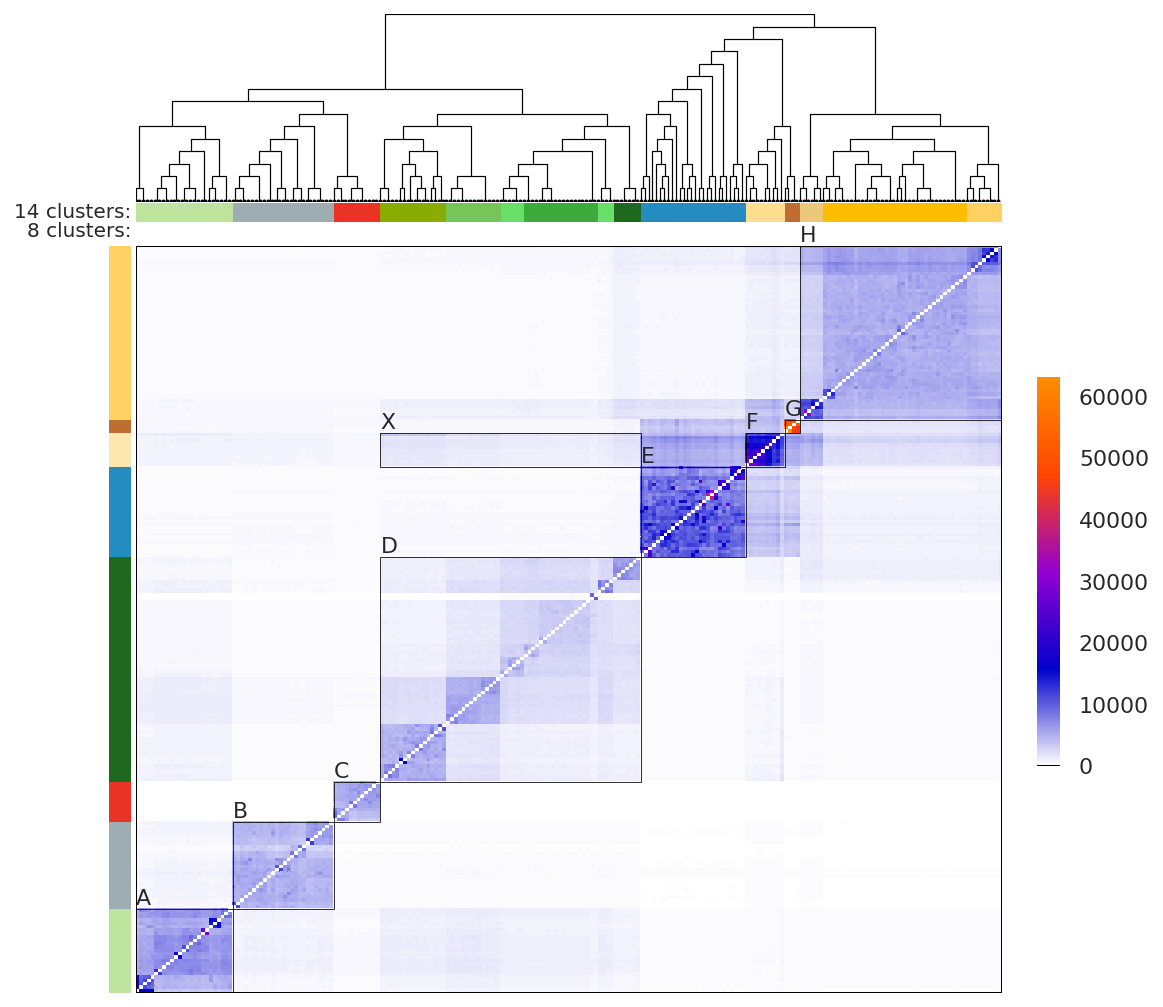

In [37]:
# three panels
fig, ((axA, ax1), (axB, ax2), (axC, ax3), (axD, ax4))  = plt.subplots(4, 2, sharex='col', sharey='row',
                        gridspec_kw={'height_ratios':[10,1,1,40], 
                                     'width_ratios':[1,40],
                                     'hspace':0.01,
                                     'wspace':0.01}, 
                        figsize=(8, 9))

# remove axes we do not need
axA.remove()
axB.remove()
axC.remove()

# plot the tree in top panel
leaf_info = plot_tree(Tree(tree), ax1, flip=True, 
                      axis=False, linewidth=0.6,
                      markers=True, 
                      markersize=1,
                      labels=False,
                      margins=(0, 0, 0, 0), 
                      fontsize=4)

# add colored rectangles for or each individual cluster membership
for i, indiv in enumerate(matrix_order):
    ax2.add_patch(Rectangle((i, 0), 1, 1, linewidth=0, edgecolor='black', facecolor=cluster_color[indiv]))
ax2.text(-1, -0.5, '8 clusters:', fontsize=10, verticalalignment='center', horizontalalignment='right')
ax2.text(-1, 0.5, '14 clusters:', fontsize=10, verticalalignment='center', horizontalalignment='right')  
    
# add colored rectangles for each individual to the middle
#for i, indiv in enumerate(matrix_order):
#    ax3.add_patch(Rectangle((i, 0), 1, 1, linewidth=0, edgecolor='black', facecolor=species_color[indiv]))
for i, indiv in enumerate(matrix_order[::-1]):
    axD.add_patch(Rectangle((0, i), 1, 1, linewidth=0, edgecolor='black', facecolor=species_color[indiv]))
#ax3.text(-30, 0.5, 'Species', fontsize=10, verticalalignment='center', horizontalalignment='right')  

# extra axes for heatmap color bar to allow x sharing of the other three axes
cbar_ax = fig.add_axes([.93, .3, .02, .3])
# plot heatmap in bottom panel
colors = ['white', 'mediumblue', 'darkviolet', 'orangered',  'darkorange'] 
cmap = LinearSegmentedColormap.from_list('custom colormap', colors, N=256)
sns.heatmap(ordered_matrix.to_numpy(), cmap=cmap, ax=ax4, cbar_ax=cbar_ax)
#sns.heatmap(ordered_matrix.to_numpy(), cmap=cmap, ax=ax4, cbar_ax=cbar_ax, vmax=40000)

# add squares with labels along diagonal (maybe to label indentified clusters)
fontsize=11
for label, start, size in [('A', 0, 25), ('B', 25, 26), ('C', 51, 12), ('D', 63, 67),
                          ('E', 130, 27), ('F', 157, 10), ('G', 167, 4), ('H', 171, 52)]:
    ax4.add_patch(Rectangle((start, ordered_matrix.shape[0] - start), size, - size, 
                            linewidth=0.4, edgecolor='black', facecolor='none'))
    ax4.text(start, ordered_matrix.shape[0] - start-size, label, fontsize=fontsize,
                    verticalalignment='bottom', 
                    horizontalalignment='left')    

# some additional squares (maybe to highlight particular admixture signals)
label, x, y, width, height = 'X', 63, 157, 67, 10
ax4.add_patch(Rectangle((x, ordered_matrix.shape[0] - y), width, -height, 
                        linewidth=0.4, edgecolor='black', facecolor='none'))
ax4.text(x, ordered_matrix.shape[0] - y-height, label, fontsize=fontsize,
                verticalalignment='bottom', 
                horizontalalignment='left')    
    
# remove axes from all plots
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
axD.axis('off')

# lines around the colorbar
cbar_ax.axhline(y=0, color='black',linewidth=1)
cbar_ax.tick_params(right=False)

# lines around the matrix
ax4.axhline(y=0, color='black',linewidth=1)
ax4.axvline(x=0, color='black',linewidth=1)
ax4.axhline(y=ordered_matrix.shape[1], color='black',linewidth=1, zorder=1000)
ax4.axvline(x=ordered_matrix.shape[0], color='black',linewidth=1, zorder=1000)

plt.savefig("../figures/fineSTRUCTURE.pdf", dpi=300, bbox_inches='tight')

In [43]:
eastern_yellows = meta_data_samples.loc[meta_data_samples.C_origin == "Cynocephalus, Central Tanzania"].PGDP_ID

In [56]:
meta_data_samples.loc[meta_data_samples.Origin == "Selous, Tanzania"]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin
46,PD_0235,01SGM1270217,Knauf/Chuma/Roos,Papio,cynocephalus,"Selous, Tanzania",M,"Selous, Nyangayane Road, Sinza, Dar es Salaam,...",39.235223,-6.78703,46,"Cynocephalus, Central Tanzania"
47,PD_0236,04SGM2030317,Knauf/Chuma/Roos,Papio,cynocephalus,"Selous, Tanzania",M,"Selous, Nyangayane Road, Sinza, Dar es Salaam,...",39.235223,-6.78703,47,"Cynocephalus, Central Tanzania"
48,PD_0237,07SGF1050317,Knauf/Chuma/Roos,Papio,cynocephalus,"Selous, Tanzania",F,"Selous, Nyangayane Road, Sinza, Dar es Salaam,...",39.235223,-6.78703,48,"Cynocephalus, Central Tanzania"


In [58]:
meta_data_samples.loc[meta_data_samples.PGDP_ID == "PD_0757"]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin
189,PD_0757,16082_5009,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",M,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,189,"Cynocephalus, Central Tanzania"


In [50]:
ordered_matrix.loc[ordered_matrix.index.isin(eastern_yellows)]

,PD_0734,PD_0736,PD_0739,PD_0740,PD_0744,PD_0721,PD_0726,PD_0722,PD_0720,PD_0743,...,PD_0768,PD_0757,PD_0236,PD_0237,PD_0235,PD_0223,PD_0225,PD_0226,PD_0227,PD_0224
Recipient,,,,,,,,,,,,,,,,,,,,,
PD_0224,500.176518,507.679699,500.688614,495.223576,507.407838,519.190388,518.959780,518.907628,537.472373,554.915688,...,5572.34656,6664.15408,6821.80571,6500.40574,6937.04654,7618.33002,7539.49680,7337.28950,7754.68391,0.00000
PD_0227,425.295671,429.847434,445.800570,432.835510,419.976745,438.748905,445.185976,433.600726,434.698690,437.657978,...,5572.38841,7221.89585,7223.17058,7337.25364,8583.77811,12737.67660,12558.34360,15947.49230,0.00000,7420.75836
PD_0226,422.782516,424.562972,432.127314,425.440545,430.476426,439.040736,455.679449,436.494847,445.030751,466.928828,...,5508.79372,6975.21223,7742.40441,7488.63736,8158.07258,11812.46760,14500.09520,0.00000,16073.29740,6937.12898
PD_0225,434.704754,437.651355,441.833754,439.222325,440.061063,442.076708,462.644310,443.170968,451.497781,440.767727,...,5464.43514,7156.45164,7868.87154,7381.93403,8708.32919,15082.05960,0.00000,14657.96980,12712.40850,7277.11958
PD_0223,446.382085,443.219718,453.459305,442.582639,441.939168,454.804975,457.290190,460.835339,469.645920,461.921995,...,5787.91274,7383.53973,7900.86487,7522.50099,8593.95386,0.00000,15638.92540,12040.39960,13335.19670,7464.22606
PD_0235,513.196126,513.955443,525.570756,524.536575,518.827709,528.872061,537.690838,535.091857,542.087352,546.223072,...,6761.10100,8601.11604,11029.74320,10663.77960,0.00000,9996.05688,10388.77690,10046.00640,10327.18250,8221.61341
PD_0237,415.178678,409.376953,412.868187,417.010047,418.223499,424.824784,433.637717,402.168598,423.301767,410.719669,...,5826.23664,7266.26283,10871.89460,0.00000,8857.60736,7257.30978,7126.05722,7432.84927,7398.96687,6185.82182
PD_0236,417.077292,414.640584,412.664906,419.979050,421.497750,423.093869,431.495331,428.248041,432.644879,428.903738,...,5999.44674,7096.64517,0.00000,11111.66450,9293.09822,7589.10383,7741.90566,7801.89603,7339.63033,6433.45148
PD_0757,376.167242,382.725732,383.136998,378.076067,386.426302,386.340573,386.313411,383.446861,373.215030,398.038683,...,5772.81059,0.00000,6468.67928,6463.39056,6318.89502,6565.06263,6317.43374,6341.21966,6521.37675,5600.74767


In [53]:
ordered_matrix.iloc[:52]

,PD_0734,PD_0736,PD_0739,PD_0740,PD_0744,PD_0721,PD_0726,PD_0722,PD_0720,PD_0743,...,PD_0768,PD_0757,PD_0236,PD_0237,PD_0235,PD_0223,PD_0225,PD_0226,PD_0227,PD_0224
Recipient,,,,,,,,,,,,,,,,,,,,,
PD_0224,500.176518,507.679699,500.688614,495.223576,507.407838,519.190388,518.959780,518.907628,537.472373,554.915688,...,5572.34656,6664.15408,6821.80571,6500.40574,6937.04654,7618.33002,7539.49680,7337.28950,7754.68391,0.00000
PD_0227,425.295671,429.847434,445.800570,432.835510,419.976745,438.748905,445.185976,433.600726,434.698690,437.657978,...,5572.38841,7221.89585,7223.17058,7337.25364,8583.77811,12737.67660,12558.34360,15947.49230,0.00000,7420.75836
PD_0226,422.782516,424.562972,432.127314,425.440545,430.476426,439.040736,455.679449,436.494847,445.030751,466.928828,...,5508.79372,6975.21223,7742.40441,7488.63736,8158.07258,11812.46760,14500.09520,0.00000,16073.29740,6937.12898
PD_0225,434.704754,437.651355,441.833754,439.222325,440.061063,442.076708,462.644310,443.170968,451.497781,440.767727,...,5464.43514,7156.45164,7868.87154,7381.93403,8708.32919,15082.05960,0.00000,14657.96980,12712.40850,7277.11958
PD_0223,446.382085,443.219718,453.459305,442.582639,441.939168,454.804975,457.290190,460.835339,469.645920,461.921995,...,5787.91274,7383.53973,7900.86487,7522.50099,8593.95386,0.00000,15638.92540,12040.39960,13335.19670,7464.22606
PD_0235,513.196126,513.955443,525.570756,524.536575,518.827709,528.872061,537.690838,535.091857,542.087352,546.223072,...,6761.10100,8601.11604,11029.74320,10663.77960,0.00000,9996.05688,10388.77690,10046.00640,10327.18250,8221.61341
PD_0237,415.178678,409.376953,412.868187,417.010047,418.223499,424.824784,433.637717,402.168598,423.301767,410.719669,...,5826.23664,7266.26283,10871.89460,0.00000,8857.60736,7257.30978,7126.05722,7432.84927,7398.96687,6185.82182
PD_0236,417.077292,414.640584,412.664906,419.979050,421.497750,423.093869,431.495331,428.248041,432.644879,428.903738,...,5999.44674,7096.64517,0.00000,11111.66450,9293.09822,7589.10383,7741.90566,7801.89603,7339.63033,6433.45148
PD_0757,376.167242,382.725732,383.136998,378.076067,386.426302,386.340573,386.313411,383.446861,373.215030,398.038683,...,5772.81059,0.00000,6468.67928,6463.39056,6318.89502,6565.06263,6317.43374,6341.21966,6521.37675,5600.74767


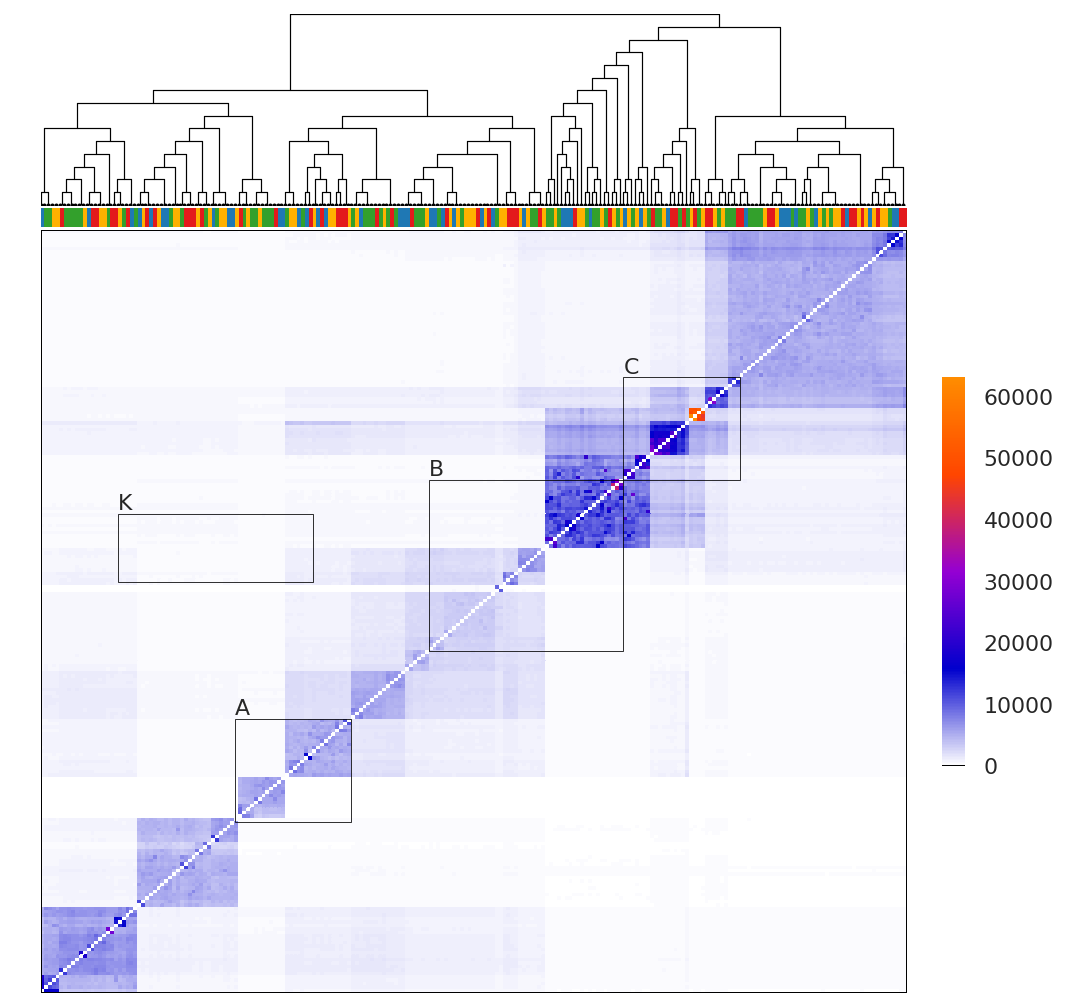

In [38]:
# three panels
fig, ((axA, ax1), (axB, ax2), (axC, ax3))  = plt.subplots(3, 2, sharex='col', sharey='row',
                        gridspec_kw={'height_ratios':[10,1,40], 
                                     'width_ratios':[1,40],
                                     'hspace':0.01,
                                     'wspace':0.01}, 
                        figsize=(8, 9))

# remove axes we do not need
axA.remove()
axB.remove()

# plot the tree in top panel
leaf_info = plot_tree(Tree(tree), ax1, flip=True, 
                      axis=False, linewidth=0.6,
                      markers=True, 
                      markersize=1,
                      labels=False,
                      margins=(0, 0, 0, 0), 
                      fontsize=4)

# add colored rectangles or each individual to the middle
for i, indiv in enumerate(matrix_order):
    ax2.add_patch(Rectangle((i, 0), 1, 1, linewidth=0, edgecolor='black', facecolor=species_colors[indiv]))
    #axC.add_patch(Rectangle((0, i), 1, 1, linewidth=0, edgecolor='black', facecolor=species_colors[indiv]))

# extra axes for heatmap color bar to allow x sharing of the other three axes
cbar_ax = fig.add_axes([.93, .3, .02, .3])
# plot heatmap in bottom panel
colors = ['white', 'mediumblue', 'darkviolet', 'orangered',  'darkorange'] 
cmap = LinearSegmentedColormap.from_list('custom colormap', colors, N=256)
sns.heatmap(ordered_matrix.to_numpy(), cmap=cmap, ax=ax3, cbar_ax=cbar_ax)

# add squares with labels along diagonal (maybe to label indentified clusters)
fontsize=11
for label, start, size in [('A', 50, 30), ('B', 100, 50), ('C', 150, 30)]:
    ax3.add_patch(Rectangle((start, ordered_matrix.shape[0] - start), size, - size, 
                            linewidth=0.4, edgecolor='black', facecolor='none'))
    ax3.text(start, ordered_matrix.shape[0] - start-size, label, fontsize=fontsize,
                    verticalalignment='bottom', 
                    horizontalalignment='left')    

# some additional squares (maybe to highlight particular admixture signals)
label, x, y, width, height = 'K', 20, 120, 50, 20
ax3.add_patch(Rectangle((x, ordered_matrix.shape[0] - y), width, -height, 
                        linewidth=0.4, edgecolor='black', facecolor='none'))
ax3.text(x, ordered_matrix.shape[0] - y-height, label, fontsize=fontsize,
                verticalalignment='bottom', 
                horizontalalignment='left')    
    
# remove axes from all plots
ax1.axis('off')
ax2.axis('off') 
ax3.axis('off') 
axC.axis('off') 

# lines around the matrix
ax3.axhline(y=0, color='black',linewidth=1)
ax3.axhline(y=ordered_matrix.shape[1], color='black',linewidth=1)
ax3.axvline(x=0, color='black',linewidth=1)
ax3.axvline(x=ordered_matrix.shape[0], color='black',linewidth=1)

# lines around the colorbar
cbar_ax.axhline(y=0, color='black',linewidth=1)
cbar_ax.tick_params(right=False)